In [18]:
using Distributions
using Plots
using DataStructures
using Random
using LinearAlgebra
using HDF5
using StatsBase

using QuantumMonteCarlo

const a = 1.0
const reference_energy = 1.715

#include("forceutil.jl")

# DMC settings
τ = .5e-2
nwalkers = 100
num_blocks = 1600
steps_per_block = Int64(1/τ)
neq = 10

# Trial wave function
function ψellipse(x::Array{Float64})
    α = a*cosh(1)
    β = a*sinh(1)
    r = (x[1]/α)^2 + (x[2]/β)^2
    max(0, 1.0 - r)
end

ψtrial = WaveFunction(
    ψellipse,
    x -> QuantumMonteCarlo.gradient_fd(ψellipse, x),
    x -> QuantumMonteCarlo.laplacian_fd(ψellipse, x)
)

# Setting up the hamiltonian
hamiltonian(ψstatus, x) = -0.5*ψstatus.laplacian
hamiltonian_recompute(ψ, x) = -0.5*ψ.laplacian(x)

model = Model(
    hamiltonian,
    hamiltonian_recompute,
    ψtrial,
)

rng = MersenneTwister(0)

# create "Fat" walkers
walkers = QuantumMonteCarlo.generate_walkers(nwalkers, ψtrial, rng, Uniform(-0.5, 0.5), 2)
fat_walkers = [QuantumMonteCarlo.FatWalker(walker, OrderedDict()) for walker in walkers]

### Actually run DMC
energies, errors = QuantumMonteCarlo.run_dmc!(
    model, 
    fat_walkers, 
    τ, 
    num_blocks, 
    steps_per_block, 
    reference_energy; 
    rng=rng, 
    neq=neq, 
    verbosity=:progressbar
);

Progress: 100%|█████████████████████████████████████████| Time: 0:04:14


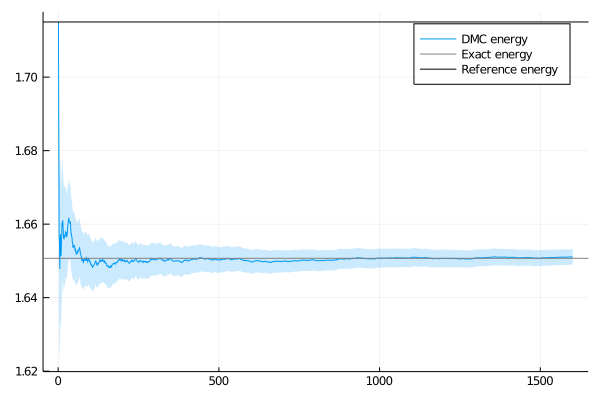

In [19]:
plot(energies, ribbon=(errors, errors), fillalpha=0.2, label="DMC energy")
hline!([1.6507], color="grey", labels="Exact energy")
hline!([reference_energy], color="black", labels="Reference energy")